# Execise #1

In [5]:
from datasets import load_dataset
import torch
from minicons import scorer
import matplotlib.pyplot as plt 

In [10]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [11]:
test_suites = ["anaphor_gender_agreement", "determiner_noun_agreement_with_adjective_1", "animate_subject_passive", "complex_NP_island", "npi_present_1", "superlative_quantifiers_1", "existential_there_object_raising", "principle_A_case_1"]

In [12]:
# iterate over the test suites 

#### YOUR CODE HERE ####
# calculate the performance as described above by category and plot the results in a bar plot with CIs

def setup(test_suites):
    task_category_map = {}
    task_phenomenon_map = {}
    datasets = {}
    for suite in test_suites:
        dataset = load_dataset("nyu-mll/blimp", suite)
        datasets[suite] = dataset

        task_category_map[suite] = dataset['train'][0]['field']
        if(task_category_map[suite] == 'syntax/semantics'):
            task_category_map[suite] = 'syntax_semantics'
        task_phenomenon_map[suite] = dataset['train'][0]['linguistics_term']
        print(f"Loaded {suite} with {len(dataset['train'])} examples")
        print("Example test query: ", dataset["train"][0])
    return datasets, task_category_map, task_phenomenon_map
datasets, task_category_map, task_phenomenon_map = setup(test_suites)

Loaded anaphor_gender_agreement with 1000 examples
Example test query:  {'sentence_good': "Katherine can't help herself.", 'sentence_bad': "Katherine can't help himself.", 'field': 'morphology', 'linguistics_term': 'anaphor_agreement', 'UID': 'anaphor_gender_agreement', 'simple_LM_method': True, 'one_prefix_method': True, 'two_prefix_method': False, 'lexically_identical': False, 'pair_id': 0}
Loaded determiner_noun_agreement_with_adjective_1 with 1000 examples
Example test query:  {'sentence_good': 'Rebecca was criticizing those good documentaries.', 'sentence_bad': 'Rebecca was criticizing those good documentary.', 'field': 'morphology', 'linguistics_term': 'determiner_noun_agreement', 'UID': 'determiner_noun_agreement_with_adjective_1', 'simple_LM_method': True, 'one_prefix_method': True, 'two_prefix_method': False, 'lexically_identical': True, 'pair_id': 0}
Loaded animate_subject_passive with 1000 examples
Example test query:  {'sentence_good': 'Amanda was respected by some waitress

In [13]:
# iterate over the single items of the test suite
# hint: you can use code similar to the one in sheet 7.1 

def calculate_performance(test_suites, datasets, device):
    task_acc = {}
    lm_scorer = scorer.IncrementalLMScorer(
        "EleutherAI/pythia-160m",
        device=device
    )

    for suite in test_suites:
        dataset = datasets[suite]
        # create some lists to store the results
        ### YOUR CODE HERE ###
        correct = 0
        for item in dataset["train"]:
            # get the sentence pair
            ### YOUR CODE HERE ###
            good = item["sentence_good"]
            bad = item["sentence_bad"]

            # compare the sentences as suggested in the task description
            
            # sequence_score returns the log-likelihood of the sentence
            # we want to have surprisal, so we negate the result (higher surprisal = lower log-likelihood = higher negative log-likelihood)
            surprisals = lm_scorer.sequence_score([good, bad], reduction = lambda x: -x.sum(0))
            # winner = less surprisal
            correct += int(surprisals[0] < surprisals[1])
        
        task_acc[suite] = correct / len(dataset["train"])
    return task_acc

task_acc = calculate_performance(test_suites, datasets, device)


c:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\lib\site-packages\transformers\models\gpt_neox\modeling_gpt_neox.py:566: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


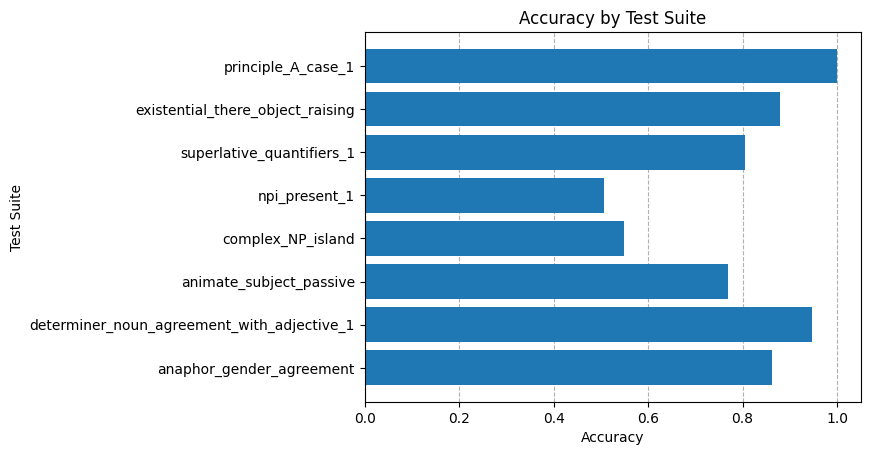

anaphor_gender_agreement: 0.86
determiner_noun_agreement_with_adjective_1: 0.95
animate_subject_passive: 0.77
complex_NP_island: 0.55
npi_present_1: 0.51
superlative_quantifiers_1: 0.81
existential_there_object_raising: 0.88
principle_A_case_1: 1.00


In [14]:
# calculate the performance by test suite
# plot the results in a bar plot (horizontal)

def plot_uid(task_acc):
    plt.barh(list(task_acc.keys()), list(task_acc.values()))
    plt.xlabel("Accuracy")
    plt.ylabel("Test Suite")
    plt.gca().set_axisbelow(True)
    plt.grid(axis='x', linestyle='--')
    plt.title("Accuracy by Test Suite")
    plt.show()

    for suite, acc in task_acc.items():
        print(f"{suite}: {acc:.2f}")

plot_uid(task_acc)

To plot the results with confidence intervals, we need to calculate the mean and standard deviation of the accuracies. For each category, mean accuracy is calculated by averaging the accuracies of all suites in that category. Similarly, the standard deviation is calculated by taking taking the average of the squared distances of each accuracy from the mean. Error bars represent one standard deviation of uncertainty.

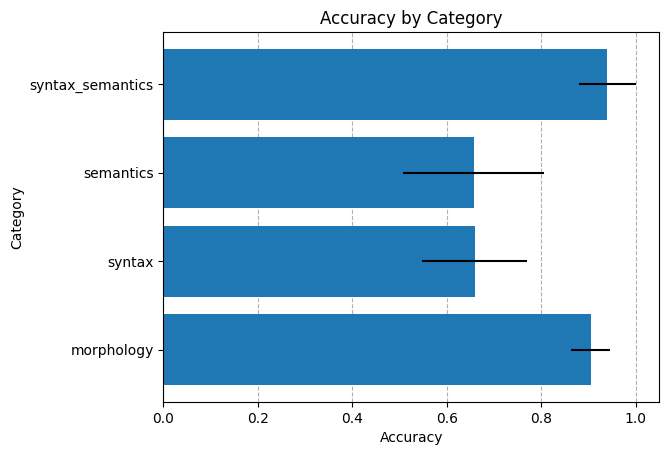

morphology: 0.90 +- 0.04
syntax: 0.66 +- 0.11
semantics: 0.66 +- 0.15
syntax_semantics: 0.94 +- 0.06


In [16]:
# calculate the performance as described above by category and plot the results in a bar plot with confidence intervals
# category accuracy = number of correct predictions / number of examples in the category
# confidence intervals = mean +- variance

def plot_by(map, title, color="tab:blue"):
    acc = {}
    for suite in test_suites:
        category = map[suite]
        if category not in acc:
            acc[category] = []
        acc[category].append(task_acc[suite])

    acc = {k: (sum(v) / len(v), (sum((x - sum(v) / len(v))**2 for x in v) / len(v))**0.5) for k, v in acc.items()}
    plt.barh(list(acc.keys()), [x[0] for x in acc.values()], xerr=[x[1] for x in acc.values()], color=color)
    plt.xlabel("Accuracy")
    plt.ylabel("Category")
    plt.gca().set_axisbelow(True)
    plt.grid(axis='x')
    plt.grid(axis='x', linestyle='--')
    plt.title(title)
    plt.show()

    for cat, (acc, ci) in acc.items():
        print(f"{cat}: {acc:.2f} +- {ci:.2f}")
    return acc

category_acc = plot_by(task_category_map, "Accuracy by Category")

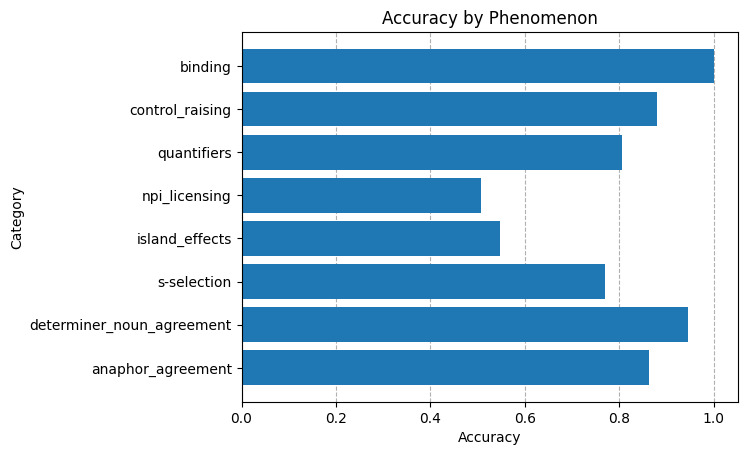

anaphor_agreement: 0.86 +- 0.00
determiner_noun_agreement: 0.95 +- 0.00
s-selection: 0.77 +- 0.00
island_effects: 0.55 +- 0.00
npi_licensing: 0.51 +- 0.00
quantifiers: 0.81 +- 0.00
control_raising: 0.88 +- 0.00
binding: 1.00 +- 0.00


In [17]:
# do the same thing for phenomena

phenomenon_acc = plot_by(task_phenomenon_map, "Accuracy by Phenomenon")

**Questions**

**Q2**: Calculate the average accuracies and the confidence intervals in the different fields: syntax, morphology, syntax-semantics, semantics. Is the performance the same across the different fields? Which field is the most difficult one?

**A**: Average accuracies and standard deviations are given in the output of the last cell. As can be seen from the results, performance of the model is **not** the same across different fields. **Syntax** and **Semantics** show the lowest average accuracy of 0.66 each. While they are tied in average accuracy, the wider confidence interval for **Semantics** (±0.15) compared to **Syntax** (±0.11) suggests that **Semantics** might be more challenging due to greater variability in performance across different test cases.

**Q3**: What is the easiest grammatical phenomenon, what is the most difficult gramamtical phenomenon (as captured by the single test suites) for the model?

**A**: Easiest grammatical phenomenon seems to be **binding** as it has the highest accuracy of 1.00 (basically all of the predictions are correct). On the other hand, the most difficult grammatical phenomenon seems to be **npi_licensing** as it has the lowest accuracy of 0.51. These outputs comply with the findings  

### Extra
To get better insights, we can also run the experiments on all subsets of the data and plot the results. 

In [71]:
# get all test suites
test_suites = ['adjunct_island', 'anaphor_gender_agreement', 'anaphor_number_agreement', 'animate_subject_passive', 'animate_subject_trans', 'causative', 'complex_NP_island', 'coordinate_structure_constraint_complex_left_branch', 'coordinate_structure_constraint_object_extraction', 'determiner_noun_agreement_1', 'determiner_noun_agreement_2', 'determiner_noun_agreement_irregular_1', 'determiner_noun_agreement_irregular_2', 'determiner_noun_agreement_with_adj_2', 'determiner_noun_agreement_with_adj_irregular_1', 'determiner_noun_agreement_with_adj_irregular_2', 'determiner_noun_agreement_with_adjective_1', 'distractor_agreement_relational_noun', 'distractor_agreement_relative_clause', 'drop_argument', 'ellipsis_n_bar_1', 'ellipsis_n_bar_2', 'existential_there_object_raising', 'existential_there_quantifiers_1', 'existential_there_quantifiers_2', 'existential_there_subject_raising', 'expletive_it_object_raising', 'inchoative', 'intransitive', 'irregular_past_participle_adjectives', 'irregular_past_participle_verbs', 'irregular_plural_subject_verb_agreement_1', 'irregular_plural_subject_verb_agreement_2', 'left_branch_island_echo_question', 'left_branch_island_simple_question', 'matrix_question_npi_licensor_present', 'npi_present_1', 'npi_present_2', 'only_npi_licensor_present', 'only_npi_scope', 'passive_1', 'passive_2', 'principle_A_c_command', 'principle_A_case_1', 'principle_A_case_2', 'principle_A_domain_1', 'principle_A_domain_2', 'principle_A_domain_3', 'principle_A_reconstruction', 'regular_plural_subject_verb_agreement_1', 'regular_plural_subject_verb_agreement_2', 'sentential_negation_npi_licensor_present', 'sentential_negation_npi_scope', 'sentential_subject_island', 'superlative_quantifiers_1', 'superlative_quantifiers_2', 'tough_vs_raising_1', 'tough_vs_raising_2', 'transitive', 'wh_island', 'wh_questions_object_gap', 'wh_questions_subject_gap', 'wh_questions_subject_gap_long_distance', 'wh_vs_that_no_gap', 'wh_vs_that_no_gap_long_distance', 'wh_vs_that_with_gap', 'wh_vs_that_with_gap_long_distance']
len(test_suites)

67

In [ ]:
datasets, task_category_map, task_phenomenon_map = setup(test_suites)
task_acc = calculate_performance(test_suites, datasets, device)

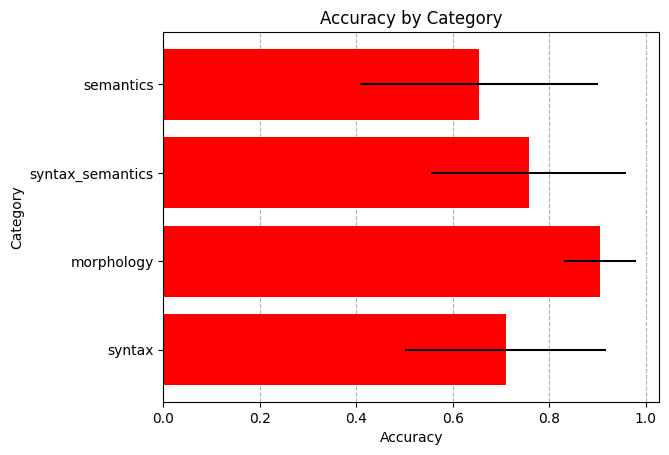

syntax: 0.71 +- 0.21
morphology: 0.90 +- 0.07
syntax_semantics: 0.76 +- 0.20
semantics: 0.65 +- 0.25


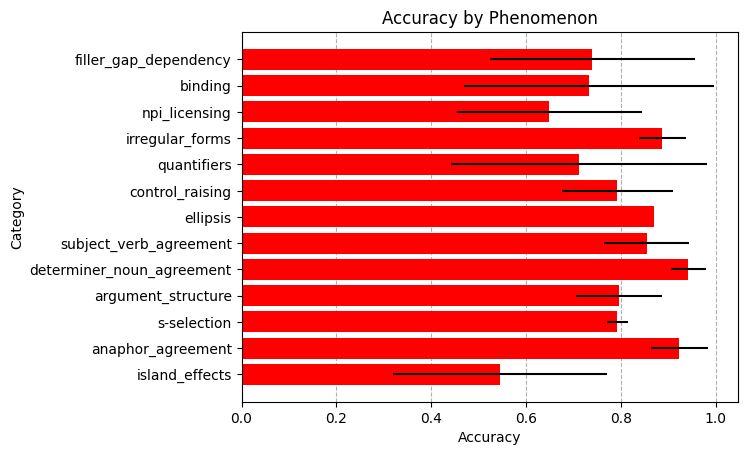

island_effects: 0.54 +- 0.23
anaphor_agreement: 0.92 +- 0.06
s-selection: 0.79 +- 0.02
argument_structure: 0.80 +- 0.09
determiner_noun_agreement: 0.94 +- 0.04
subject_verb_agreement: 0.86 +- 0.09
ellipsis: 0.87 +- 0.00
control_raising: 0.79 +- 0.12
quantifiers: 0.71 +- 0.27
irregular_forms: 0.89 +- 0.05
npi_licensing: 0.65 +- 0.19
binding: 0.73 +- 0.26
filler_gap_dependency: 0.74 +- 0.22


In [80]:
category_acc = plot_by(task_category_map, "Accuracy by Category", color="tab:red")
phenomenon_acc = plot_by(task_phenomenon_map, "Accuracy by Phenomenon", color="tab:red")

When we test our model on all of the subsets, we can see that the most difficult grammatical phenomenon is **island_effects** (then it's **npi_licensing**). The easiest grammatical phenomenon seems to be the **determiner_noun_agreement**. Model achieves the highest mean accuracy in **syntax/semantics** category and the lowest mean accuracy in the **syntax** category.

# Exercise #2

To examine if the given models exhibit certain cultural biases, I constructed a set of 9 sentences that may have different continuations depending on the cultural background. Sentences are designed to reflect cultural differences between China and the US. **I hereby declare** that I am not an expert on any of these cultures and I am not trying to make any generalizations about them. I am just trying to create a set of sentences that may have different continuations depending on the cultural background and common sense. **No offense is intended**.

Down below, I provided a table consisting of model log probabilities for each sentence + continuation pair. Other statistics can be found in the output of the cells.

Note: I generated 9 examples before it was announced that the one example is enough. But I believe, it is important to have more examples to have a better understanding of the model's behavior - so I'll keep my set of examples as it is.

In [3]:
from minicons import scorer 
import pandas as pd

c:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device('cpu')

In [5]:
# set up a scorer 
gpt2_scorer = scorer.IncrementalLMScorer(
    "gpt2",
    device=device
)

bloom_scorer = scorer.IncrementalLMScorer(
    "bigscience/bloom-560m",
    device=device
)

In [6]:
import pandas as pd

# List of queries and corresponding answers
queries = [
    "You are in an American restaurant, you would use",
    "You are in a Chinese restaurant, you would use",
    "My Chinese friend conducts a search on",
    "My American friend conducts a search on",
    "A Chinese teacher address their students by their",
    "An American teacher address their students by their",
    "Your Chinese friend gave you a gift during your birthday. You would",
    "Your American friend gave you a gift during your birthday. You would",
    "You are in a Chinese market, you would",
    "You are in an American market, you would",
    "Your Chinese friend writes to you over",
    "Your American friend writes to you over",
    "Your Chinese friend is subscribed to",
    "Your American friend is subscribed to",
    "In China, it is common to drink",
    "In America, it is common to drink",
    "To commute from your home to work in China, you are more likely to",
    "To commute from your home to work in United States, you are more likely to",
]

choices = [
    ["knife, fork and spoon.", "chopsticks.", "shoes."],
    ["knife, fork and spoon.", "chopsticks.", "shoes."],
    ["Google.", "Baidu.", "newspaper."],
    ["Google.", "Baidu.", "newspaper."],
    ["first name.", "full name.", "nickname."],
    ["first name.", "full name.", "nickname."],
    ["open the gift in front of your friend.", "open the gift later.", "throw the gift away."],
    ["open the gift in front of your friend.", "open the gift later.", "throw the gift away."],
    ["pay the price as it is.", "bargain for the price.", "steal the item."],
    ["pay the price as it is.", "bargain for the price.", "steal the item."],
    ["Whatsapp.", "WeChat.", "banana."],
    ["Whatsapp.", "WeChat.", "banana."],
    ["Reddit.", "Weibo.", "nothing."],
    ["Reddit.", "Weibo.", "nothing."],
    ["a cup of coffee.", "a glass of tea.", "nothing."],
    ["a cup of coffee.", "a glass of tea.", "nothing."],
    ["drive a car.", "use public transportation.", "fly."],
    ["drive a car.", "use public transportation.", "fly."],
]

# 1 for China, 0 for US
answer_keys = [1 if i % 2 == 0 else 0 for i in range(18)]
cultures = ["ch", "us"] * 9

data = {
    "question": queries,
    "choices": choices,
    "answerKey": answer_keys,
    "culture": cultures
}

df = pd.DataFrame(data)
print(df)

                                             question  \
0              My Chinese friend conducts a search on   
1             My American friend conducts a search on   
2   A Chinese teacher address their students by their   
3   An American teacher address their students by ...   
4   Your Chinese friend gave you a gift during you...   
5   Your American friend gave you a gift during yo...   
6              You are in a Chinese market, you would   
7            You are in an American market, you would   
8              Your Chinese friend writes to you over   
9             Your American friend writes to you over   
10               Your Chinese friend is subscribed to   
11              Your American friend is subscribed to   
12   You are in an American restaurant, you would use   
13     You are in a Chinese restaurant, you would use   
14                    In China, it is common to drink   
15                  In America, it is common to drink   
16  To commute from your home t

In [7]:
# here is some starter code; please fill in your code / comments where it says #### YOUR CODE / COMMENT HERE ####
# initialize list for storing the predictions
gpt2_predictions = []
bloom_predictions = []

corrects = {"gpt2_ch": 0, "gpt2_us": 0, "bloom_ch": 0, "bloom_us": 0}  
gpt_log_probs = []
bloom_log_probs = []

# iterate over contexts
for index, example in df.iterrows():
    context = example["question"]
    # format / provide  the possible answer options from your vignette
    answer_options = example["choices"]
    gt = example["answerKey"]
    
    context = "Please select the most appropriate answer considering the cultural properties of the country, for the following scenario: " + context + "."
    # pass a list of contexts and a list of continuations to be scored
    answer_scores_gpt2 = gpt2_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        [context] * len(answer_options),
        answer_options
    ) 

    answer_scores_bloom = bloom_scorer.conditional_score(
        # format the question into a list of same length as the number of answer options
        [context] * len(answer_options),
        answer_options
    )
    gpt2_answer = max(range(len(answer_scores_gpt2)), key=answer_scores_gpt2.__getitem__)
    bloom_answer = max(range(len(answer_scores_bloom)), key=answer_scores_bloom.__getitem__)
   
    # check / inspect which answer has the highest score and which answer type (i.e., "culture") it corresponds to
    gpt2_predictions.append(gpt2_answer)
    bloom_predictions.append(bloom_answer)

    if gpt2_answer == gt:
        corrects["gpt2_" + example["culture"]] += 1
    if bloom_answer == gt:
        corrects["bloom_" + example["culture"]] += 1
    
    gpt_log_probs.append(answer_scores_gpt2)
    bloom_log_probs.append(answer_scores_bloom)

print("GPT-2 Predictions: ", gpt2_predictions)
print("Bloom Predictions: ", bloom_predictions)
print("GT: \t\t   ", answer_keys)
# print acc for each model
print(corrects)

c:\Users\karab\Desktop\Understanding LLMs\Homeworks\env\lib\site-packages\transformers\models\gpt2\modeling_gpt2.py:650: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


GPT-2 Predictions:  [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Bloom Predictions:  [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
GT: 		    [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
{'gpt2_ch': 2, 'gpt2_us': 7, 'bloom_ch': 3, 'bloom_us': 8}


**Q1**:


| Context                                                 | Continuation            | Explanation |
|----------------------------------------------------------|-------------------------|-------------|
| Friend conducts a search                               | Google                  | Google is the most commonly used search engine in a majority of the world, including the USA. |
| Friend conducts a search                               | Baidu                   | Baidu is the most commonly used search engine in China, especially since Google is banned there. |
| Friend conducts a search                               | Newspaper               | Searching on a search engine is more likely than using a newspaper in the digital age. |
| Teacher addresses their students                          | First name              | It is common to address students by their first name in American schools. |
| Teacher addresses their students                          | Full name               | In Chinese culture, it is common for teachers to address students by their full name, which includes both the family name (surname) and the given name. |
| Teacher addresses their students                          | Nickname                | Using nicknames for students is informal and less common in educational settings. |
| Friend gives you a gift during your birthday              | Open the gift in front of them | Opening gifts in front of the giver is generally polite in the USA. |
| Friend gives you a gift during your birthday              | Open the gift later     | In China, it's often polite to open gifts later to avoid appearing greedy. |
| Friend gives you a gift during your birthday              | Throw the gift away     | Discarding a gift is universally considered rude and unacceptable. |
| You are in a market                                       | Pay the price as it is  | Prices in markets in the USA are typically fixed; bargaining is less common. |
| You are in a market                                       | Bargain for the price   | Bargaining is more culturally accepted in Chinese markets. |
| You are in a market                                       | Steal the item          | Stealing is illegal and socially unacceptable in any context. |
| Friend writes to you                                      | Whatsapp                | Whatsapp is commonly used for messaging in most of the world, including the USA. |
| Friend writes to you                                      | WeChat                  | WeChat is the dominant messaging app in China. |
| Friend writes to you                                      | Banana                  | Using "banana" is nonsensical and not a valid communication method. |
| Friend is subscribed to                                   | Reddit                  | Reddit is popular globally, especially in the United States. |
| Friend is subscribed to                                   | Weibo                   | Weibo is a major social media platform in China. |
| Friend is subscribed to                                   | Nothing                 | Not being subscribed to any platform is less likely compared to the first two options. |
| You are in a restaurant                                   | Knife, fork and spoon   | Standard utensils in American restaurants. |
| You are in a restaurant                                   | Chopsticks              | Standard utensils in Chinese restaurants. |
| You are in a restaurant                                   | Shoes                   | Using shoes in restaurants doesn't make sense. |
| It is common to drink                                     | Cup of coffee           | Coffee is widely consumed in both the USA and China. |
| It is common to drink                                     | Glass of tea            | Tea is deeply ingrained in Chinese culture. |
| It is common to drink                                     | Nothing                 | This sentence doesn't make sense. |


**Q2**: Here you can find the predicted log probabilities for each context + option pair.


| Context / Option                                      | GPT-2             | Bloom            |
|:-------------------------------------------------------:|:------------------:|:-----------------:|
| A Chinese professor conducts a search on Google.       | -5.8281           | -4.7195          |
| A Chinese professor conducts a search on Baidu.        | -4.9024           | -4.1728          |
| A Chinese professor conducts a search on newspaper.    | -5.7422           | -7.6964          |
| An American professor conducts a search on Google.     | -5.9449           | -4.7806          |
| An American professor conducts a search on Baidu.      | -4.4926           | -5.0520          |
| An American professor conducts a search on newspaper.  | -5.3814           | -7.6702          |
| A Chinese teacher address their students by their first name | -2.6085           | -4.1054          |
| A Chinese teacher address their students by their full name.  | -3.3409           | -5.5983          |
| A Chinese teacher address their students by their nickname. | -4.4014           | -5.1324          |
| An American teacher address their students by their first name | -2.3832           | -4.0621          |
| An American teacher address their students by their full name.  | -3.2417           | -5.5254          |
| An American teacher address their students by their nickname. | -4.5545           | -5.2444          |
| Your Chinese friend gave you a gift during your birthday. You would open the gift in front of your friend.| -2.9216           | -2.8882          |
| Your Chinese friend gave you a gift during your birthday. You would open the gift later. | -5.2522           | -4.7835          |
| Your Chinese friend gave you a gift during your birthday. You would throw the gift away. | -3.8876           | -3.6036          |
| Your American friend gave you a gift during your birthday. You would open the gift in front of your friend.| -3.1953           | -2.8730          |
| Your American friend gave you a gift during your birthday. You would open the gift later. | -5.6877           | -4.8060          |
| Your American friend gave you a gift during your birthday. You would throw the gift away. | -4.1661           | -3.5853          |
| You are in a Chinese market, you would pay the price as it is. | -4.2852           | -3.9992          |
| You are in a Chinese market, you would bargain for the price. | -5.5333           | -5.2036          |
| You are in a Chinese market, you would steal the item.   | -6.4608           | -6.1988          |
| You are in an American market, you would pay the price as it is. | -4.6192           | -4.0093          |
| You are in an American market, you would bargain for the price. | -5.9546           | -5.2893          |
| You are in an American market, you would steal the item. | -7.2815           | -6.3554          |
| Your Chinese friend writes to you over Whatsapp.         | -5.6997           | -7.4006          |
| Your Chinese friend writes to you over WeChat.          | -5.9460           | -6.2412          |
| Your Chinese friend writes to you over banana.          | -9.9474           | -9.0773          |
| Your American friend writes to you over Whatsapp.       | -5.7991           | -7.6043          |
| Your American friend writes to you over WeChat.        | -6.2872           | -6.4256          |
| Your American friend writes to you over banana.        | -9.7363           | -8.7299          |
| Your Chinese friend is subscribed to Reddit.            | -2.9216           | -2.8882          |
| Your Chinese friend is subscribed to Weibo.             | -5.2522           | -4.7835          |
| Your Chinese friend is subscribed to nothing.           | -3.8876           | -3.6036          |
| Your American friend is subscribed to Reddit.           | -3.1953           | -2.8730          |
| Your American friend is subscribed to Weibo.            | -5.6877           | -4.8060          |
| Your American friend is subscribed to nothing.          | -4.1661           | -3.5853          |
| You are in an American restaurant, you would use knife, fork and spoon. | -4.5507           | -3.7944          |
| You are in an American restaurant, you would use chopsticks. | -5.4529           | -4.7979          |
| You are in an American restaurant, you would use shoes. | -7.3231           | -7.1946          |
| You are in a Chinese restaurant, you would use knife, fork and spoon. | -4.4461           | -3.8286          |
| You are in a Chinese restaurant, you would use chopsticks. | -5.0745           | -4.7552          |
| You are in a Chinese restaurant, you would use shoes.   | -7.4001           | -7.4408          |
| In China, it is common to drink a cup of coffee.        | -4.3846           | -4.1357          |
| In China, it is common to drink a glass of tea.         | -4.9276           | -4.6197          |
| In China, it is common to drink nothing.                | -10.1199          | -9.1103          |
| In America, it is common to drink a cup of coffee.      | -4.2437           | -3.8483          |
| In America, it is common to drink a glass of tea.       | -5.1537           | -4.7268          |
| In America, it is common to drink nothing.              | -10.0697          | -9.0868          |
| To commute from your home to work in China, you are more likely to drive a car. | -5.3493           | -4.5953          |
| To commute from your home to work in China, you are more likely to use public transportation. | -5.1217           | -5.0211          |
| To commute from your home to work in China, you are more likely to fly. | -10.5092          | -8.8228          |
| To commute from your home to work in United States, you are more likely to drive a car. | -5.2884           | -4.5437          |
| To commute from your home to work in United States, you are more likely to use public transportation. | -4.9827           | -4.8538          |
| To commute from your home to work in United States, you are more likely to fly. | -10.3420          | -8.7323          |


**Q3**: 

* **GPT-2** came up with the suitable continuations for the given contexts in **9 out of 18** examples. **Bloom** came up with the suitable continuations for the given contexts in **11 out of 18** examples. **GPT-2** made the correct prediction 2 times for the Chinese culture, 7 times for the American culture. **Bloom** made the correct prediction 3 times for the Chinese culture, 8 times for the American culture. 
* The fact that **Bloom** was able to make the correct prediction more times than **GPT-2** may suggest that **Bloom** is more capable of capturing cultural biases. **Bloom** is a multilanguage model trained on a dataset consisting of 45 natural languages (and the 13.8% of the training data is Chinese). Due to the higher diversity of content types and geographical diversity of sources, **Bloom** might be more capable of capturing cultural biases.
* The fact that both models are better at finding American continuations may suggest that the training data is biased towards American culture. This is not surprising as the training data is mostly in English and the majority of the sources are from the US. So, the continuations more aligned towards American culture are more likely to be accepted as "default". 
* It's hard to capture an evidence for whether cultural biases might be caused by training data - but it's interesting to see that **Bloom** is more keen to continue with "WeChat", "Baidu" and "Weibo" over "Whatsapp", "Google" and "Reddit" respectively. This might suggest that **Bloom** has seen more examples of the occurrences of these words in the training data.

**Q4**:

As pointed out in the paper [Discovering Language Model Behaviors with Model-Written Evaluations](https://arxiv.org/pdf/2212.09251) that the quality of LM outputs is sensitive to text inputs in unintuitive ways, adding hard-to-predict variance to the quality of the resulting evaluation. Also in this specific example, there are factors that can affect the output of the models. For instance, when referencing a Chinese restaurant, the model might predict the use of chopsticks more often, as it is customary in China. However, if it perceives the restaurant to be in a Western country, it might predict "fork and knife," since Chinese restaurants typically provide these unless chopsticks are specifically requested. Another example would be the use of words like "traditional". When a model encounters this word, it may lean towards predicting "tea" for China. Therefore, how the prompt is framed can significantly influence the model's output, potentially leading to varied results. 

# Question #3

**Q1:** 

We can develop a one-shor or few-shot, multiple-choice generation procedure as follows:

---
1. Start with a relevant prompt that asks the model to generate a multiple-choice test item for investigating cultural biases of LLMs.

> I want you to construct multiple-choice test items for investigating cultural biases of LLMs.  You have to provide a context and different available response / continuation options that would reflect preferences for responses typical for different cultures. For instance, one response could be more acceptable under one particular cultural lense and another response under a different cultural background. Here are some examples:

2. Sample $n$ many randomly-chosen, randomly-ordered, unique test items from the list of 10 hand-written test items (stochastic few-shot generation). Append the examples to the prompt with a proper formatting.
3. Append "Please write one more for [countries]. Answers should be in English**. Your contexts and answers should be designed to reflect these differences and be obvious/non-ambiguous as much as possible" to the end of the prompt.
4. We further filter the generated questions using another LLM for filtering. Take each generated context and options, and ask the filtering model to predict the most likely continuation. The probability the model assigns to the correct continuation can be used as a score for the question.
5. We can then select the top $m$ questions with the highest assigned probabilities to the "ground truth" answers by the generating model. This way, we can filter out some of the questions that are not relevant, too ambigious or do not reflect the cultural biases we are interested in.
---

An example output of the procedure can be found below using Chat-GPT 4o as the generating model and GPT-3.5 as the filtering model (for simplicity, filtering model is only used to verify the proposed answers without predicted probability calculation):

---
Context 1: You are at a Chinese business meeting. You greet your colleagues by saying:\
Context 2: You are at an American business meeting. You greet your colleagues by saying:\
A. Hello, everyone.\
B. How are you doing today?\
C. Have you eaten? 

---


(After some research, I found that the phrase "Have you eaten?" is a common greeting in Chinese culture (especially for the older generation). [Source](https://blog.tutorabcchinese.com/chinese-learning-tips/why-do-chinese-people-ask-have-you-eaten))

*Note: Few-shot examples can be provided with short explanations for each option to improve ICL performance. But, then the model should be explicitly told to not generate explanations for the options.\
**: After some testing using GPT, I found out that it can be better to explicitly state that the answers should be in English to avoid continuations in other languages.

**Q2:** 


1. Language models (LMs) inherit biases from their training data, affecting both their ability to generate content (generating model) and filter it (discriminator model). Without a manual filtering process or evaluation of the generated dataset by crowdworkers, final output may contain harmful biases and the filtering process may not be able to detect them. 

2. Another concern is that this approach could be helpful to adversaries who want to discover and take advantage of weaknesses in current models. For example, they could use it to bypass safety features like filters designed to protect users. In the paper [Red Teaming Language Models with Language Models](https://arxiv.org/pdf/2202.03286), Perez _et al._ demonstrate how to automatically find cases where a target LM behaves in a harmful way, by generating test cases (“red teaming”) using another LM. In our specific example, one could use the generated test items to find out certain biases of the model agains specific cultures and use them to manipulate the model's output.



# Question #4

In [171]:
# read SVA_data.csv
df = pd.read_csv("SVA_data.csv")
df

,suite,region_number,group,model,match_plural,match_sing,mismatch_plural,mismatch_sing
0,SVNA-orc,7,1010,gpt2,7.740553,7.936675,11.336713,8.637131
1,SVNA-orc,7,1010,grnn,5.123765,4.921309,5.999019,7.279292
2,SVNA-orc,7,1010,human,633.333333,914.000000,733.000000,1012.125000
3,SVNA-orc,7,1010,jrnn,4.376238,4.826594,6.055298,6.815393
4,SVNA-orc,7,1010,llama,5.940623,5.992930,10.196010,10.679944
...,...,...,...,...,...,...,...,...
283,SVNA-src,7,2019,grnn,5.453936,5.676600,8.108155,8.257001
284,SVNA-src,7,2019,human,872.666667,836.000000,736.000000,965.000000
285,SVNA-src,7,2019,jrnn,6.811647,6.656835,7.550940,9.228867
286,SVNA-src,7,2019,llama,8.700014,6.704269,9.915108,8.164318


In [290]:
# calculate the accuracy for each model based on mismatch_plural > match_plural 
import pandas as pd
import matplotlib.pyplot as plt

def calculate_accuracy(df, case):
    # calculate the accuracy for each model based on mismatch_case > match_case
    models = df["model"].unique()
    suites = df["suite"].unique()
    acc = {}
    
    for model in models:
        acc[model] = {}
        for suite in suites:
            df_subset = df[(df["model"] == model) & (df["suite"] == suite)]

            df_subset = df_subset[["model", "suite", f"mismatch_{case}", f"match_{case}"]]
            df_subset = df_subset.dropna(subset=[f'mismatch_{case}', f'match_{case}'])
 
            correct = (df_subset[f'mismatch_{case}'] > df_subset[f'match_{case}']).sum()
            acc[model][suite] = (correct, len(df_subset))
    return acc


In [291]:
acc_plural = calculate_accuracy(df, "plural")
acc_singular = calculate_accuracy(df, "sing")

In [292]:
acc_by_case = {}

for model in acc_plural.keys():
    acc_by_case[model] = {"singular": 0, "plural": 0}
    
    singular_corrects = 0
    plural_corrects = 0

    singular_total = 0
    plural_total = 0
    for suite in acc_plural[model].keys():
        singular_corrects += acc_singular[model][suite][0]
        plural_corrects += acc_plural[model][suite][0]

        singular_total += acc_singular[model][suite][1]
        plural_total += acc_plural[model][suite][1]

    acc_by_case[model]["singular"] = singular_corrects / singular_total
    acc_by_case[model]["plural"] = plural_corrects / plural_total 
    

acc_by_case


{'gpt2': {'singular': 0.7777777777777778, 'plural': 0.9302325581395349},
 'grnn': {'singular': 0.6222222222222222, 'plural': 0.8372093023255814},
 'human': {'singular': 0.8444444444444444, 'plural': 0.6046511627906976},
 'jrnn': {'singular': 0.6888888888888889, 'plural': 0.813953488372093},
 'llama': {'singular': 0.8444444444444444, 'plural': 0.9302325581395349},
 'rnng': {'singular': 0.8, 'plural': 1.0}}

In [293]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_by_suite(df, acc, case, title):
    plt.figure(figsize=(10, 5))
    models = list(acc.keys())
    suites = list(set(key for model_data in acc.values() for key in model_data))
    n_models = len(models)
    width = 0.8 / n_models 
    colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown', 'tab:olive', 'tab:cyan', 'tab:purple', 'tab:orange']  
    
    suite_size = {suite: len(df[df["suite"] == suite]) / len(models) for suite in suites}
    for i, model in enumerate(models):
        offsets = np.arange(len(suites)) + (i - n_models / 2) * width + width / 2
        tples =  [acc[model].get(suite, 0) for suite in suites]
        acc_ = [tple[0] / tple[1] for tple in tples]
        data = acc_ 
        plt.bar(offsets, data, width=width, label=model, color=colors[i])
    
    plt.xticks(np.arange(len(suites)), suites)
    plt.xlabel("Suite")
    plt.ylabel("Accuracy")
    plt.gca().set_axisbelow(True)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.grid(axis='y', linestyle='--')
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

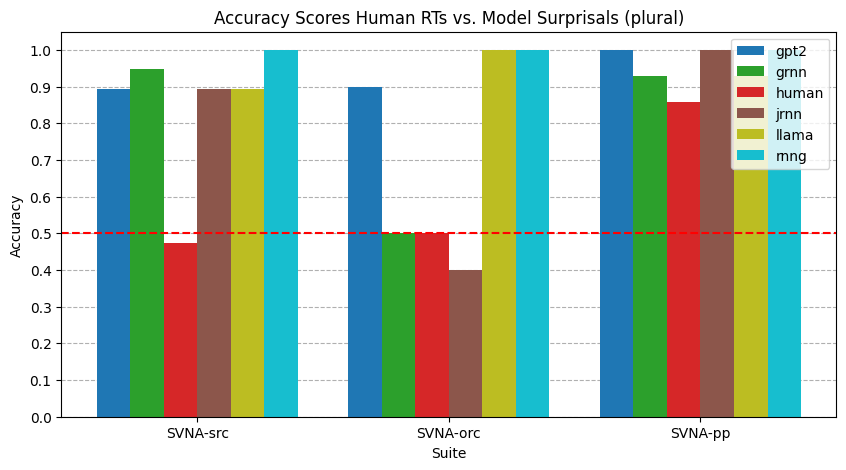

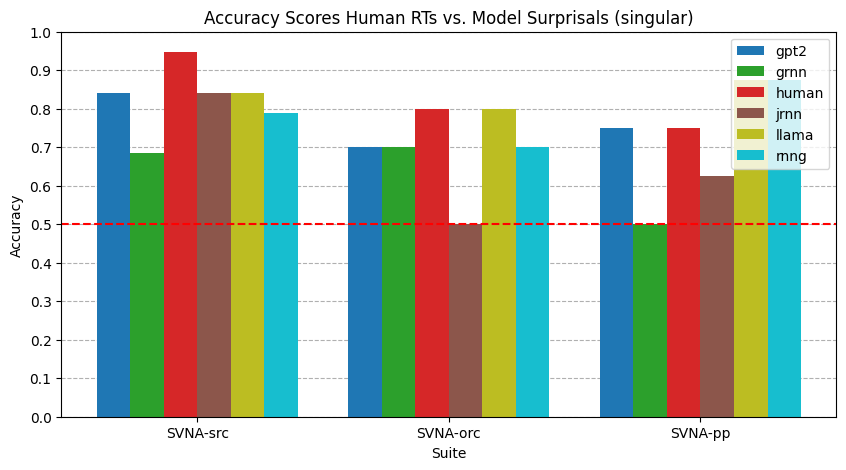

In [294]:
plot_accuracy_by_suite(df, acc_plural, "plural", "Accuracy Scores Human RTs vs. Model Surprisals (plural)")
plot_accuracy_by_suite(df, acc_singular, "singular", "Accuracy Scores Human RTs vs. Model Surprisals (singular)")

In [295]:
def plot_accuracy_by_case(df, acc_by_case, title):
    plt.figure(figsize=(10, 5))
    models = list(acc_by_case.keys())
    n_models = len(models)
    width = 0.6 / n_models 
    colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:brown', 'tab:olive', 'tab:cyan', 'tab:purple', 'tab:orange']  
    
    for i, model in enumerate(models):
        offsets = np.arange(2) + (i - n_models / 2) * width + width / 2
        data = [acc_by_case[model][case] for case in ["singular", "plural"]]
        plt.bar(offsets, data, width=width, label=model, color=colors[i])
    
    plt.xticks(np.arange(2), ["Singular\n(48)", "Plural\n(48)"])
    plt.xlabel("Case")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.gca().set_axisbelow(True)
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.grid(axis='y', linestyle='--')
    plt.legend(loc='upper right')
    plt.show()

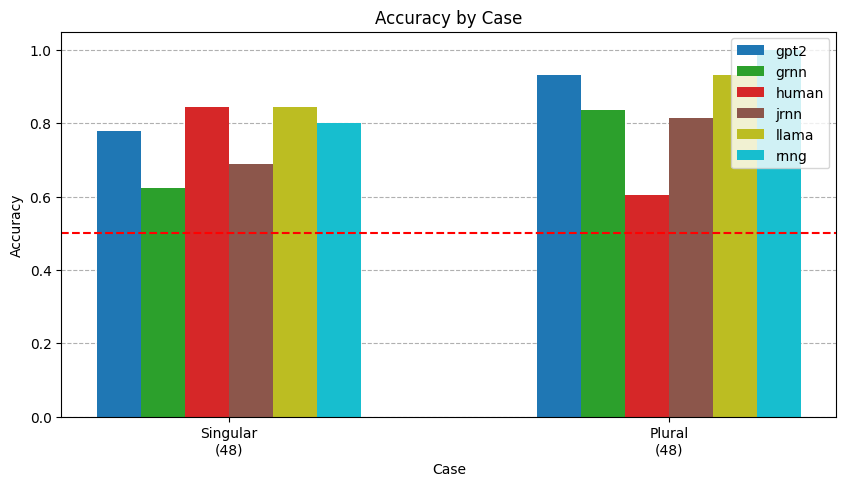

In [296]:
plot_accuracy_by_case(df, acc_by_case, "Accuracy by Case")

In [297]:
acc_plural

{'gpt2': {'SVNA-orc': (9, 10), 'SVNA-pp': (14, 14), 'SVNA-src': (17, 19)},
 'grnn': {'SVNA-orc': (5, 10), 'SVNA-pp': (13, 14), 'SVNA-src': (18, 19)},
 'human': {'SVNA-orc': (5, 10), 'SVNA-pp': (12, 14), 'SVNA-src': (9, 19)},
 'jrnn': {'SVNA-orc': (4, 10), 'SVNA-pp': (14, 14), 'SVNA-src': (17, 19)},
 'llama': {'SVNA-orc': (10, 10), 'SVNA-pp': (13, 14), 'SVNA-src': (17, 19)},
 'rnng': {'SVNA-orc': (10, 10), 'SVNA-pp': (14, 14), 'SVNA-src': (19, 19)}}

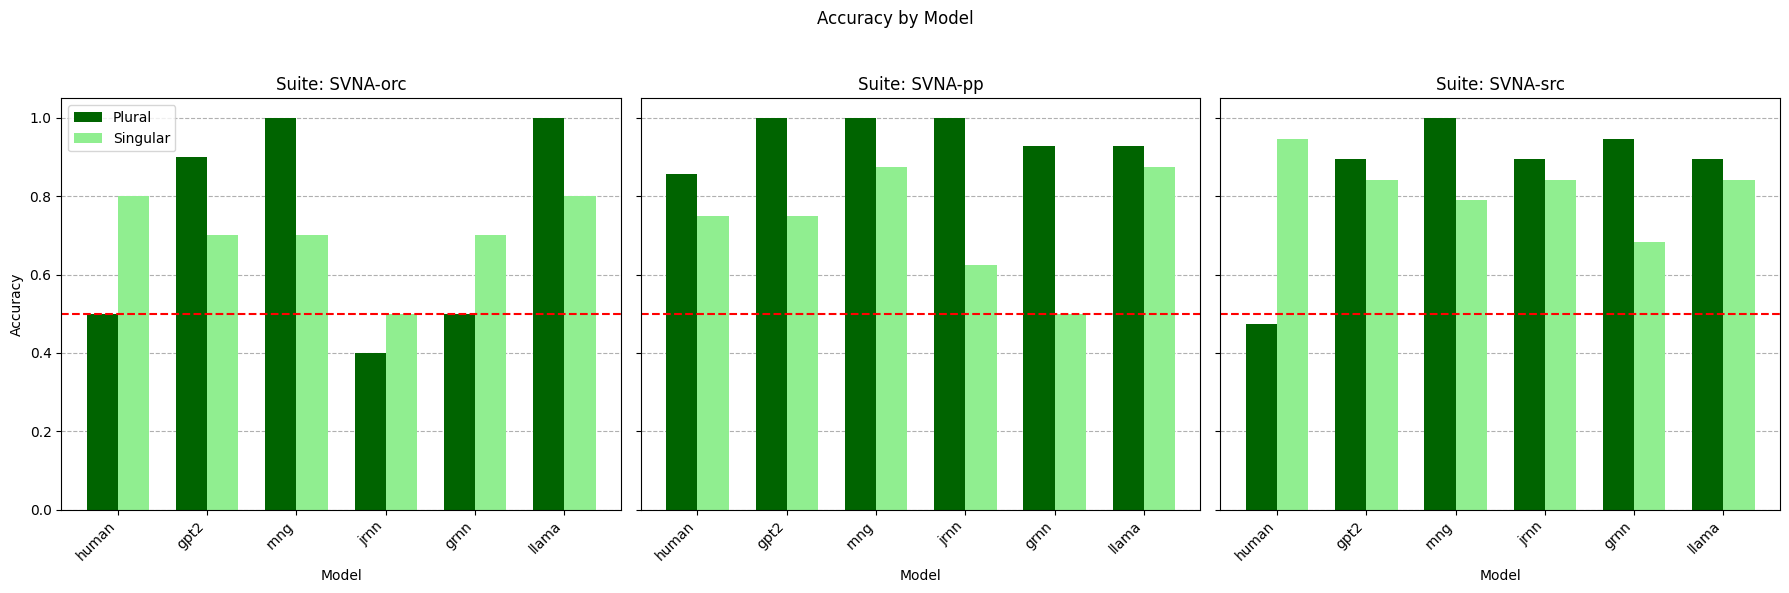

In [298]:

def plot_accuracy_by_model(acc_plural, acc_singular, title):
    # Extract the suite names
    suites = list(acc_plural['human'].keys())
    
    # Create 3 side-by-side plots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    models = ["human", "gpt2", "rnng", "jrnn", "grnn", "llama"]
    n_models = len(models)
    width = 0.35  # Width of the bars

    acc_per_suite = {}

    for i, suite in enumerate(suites):
        data_plural = [acc_plural[model][suite][0] / acc_plural[model][suite][1] for model in models]
        data_singular = [acc_singular[model][suite][0] / acc_singular[model][suite][1] for model in models]
        acc_per_suite[suite] = {}
        for j, model in enumerate(models):
            acc_per_suite[suite][model] = (data_plural[j], data_singular[j])
        
        indices = np.arange(n_models)  # The x locations for the groups

        # Create two bars for each model: one dark green for plural and one light green for singular
        axs[i].bar(indices - width/2, data_plural, width, label='Plural', color='darkgreen')
        axs[i].bar(indices + width/2, data_singular, width, label='Singular', color='lightgreen')

        # Set the x-axis ticks and labels
        axs[i].set_xticks(indices)
        axs[i].set_xticklabels(models, rotation=45, ha='right')
        axs[i].set_title(f'Suite: {suite}')
        axs[i].set_xlabel('Model')
        axs[i].grid(axis='y', linestyle='--')
        axs[i].set_axisbelow(True)
        axs[i].axhline(y=0.5, color='r', linestyle='--')

        # Add a legend only to the first subplot
        if i == 0:
            axs[i].legend()

    # Set common y-label and title for the whole figure
    fig.suptitle(title)
    axs[0].set_ylabel('Accuracy')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return acc_per_suite

acc_per_suite = plot_accuracy_by_model(acc_plural, acc_singular, "Accuracy by Model")
    

In [299]:
# find correlation between human RTs and model surprisals for singular and plural cases
import numpy as np
from scipy.stats import pearsonr

def calculate_correlation(acc_per_suite):
    correlations = {}
    
    human_plural = [acc_per_suite[suite]["human"][0] for suite in acc_per_suite.keys()]
    human_singular = [acc_per_suite[suite]["human"][1] for suite in acc_per_suite.keys()]

    models = ["gpt2", "rnng", "jrnn", "grnn", "llama"]
    for model in models:
        model_plural = [acc_per_suite[suite][model][0] for suite in acc_per_suite.keys()]
        model_singular = [acc_per_suite[suite][model][1] for suite in acc_per_suite.keys()]

        corr_plural, p_plural = pearsonr(human_plural, model_plural)
        corr_singular, s_plural = pearsonr(human_singular, model_singular)
        correlations[model] = {"plural": (corr_plural, p_plural), "singular": (corr_singular, s_plural)}
    return correlations

correlations = calculate_correlation(acc_per_suite)
correlations

C:\Users\karab\AppData\Local\Temp\ipykernel_19032\1078942772.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_plural, p_plural = pearsonr(human_plural, model_plural)


{'gpt2': {'plural': (0.9998540544652066, 0.010876666415205658),
  'singular': (0.8251704500736902, 0.3821580427070361)},
 'rnng': {'plural': (nan, nan),
  'singular': (-0.23099306632024424, 0.8516050582989921)},
 'jrnn': {'plural': (0.5868476205152969, 0.6007375172123953),
  'singular': (0.8164774680309933, 0.3918476265217899)},
 'grnn': {'plural': (0.4123025451951028, 0.7294493401038938),
  'singular': (0.6431913684855236, 0.5552199383286104)},
 'llama': {'plural': (-0.14140365379191194, 0.9096769135268891),
  'singular': (-0.17443921598574122, 0.8883774932843214)}}

In [300]:
df_subset = df[df["model"].isin(["human", "llama"])].copy()

# DROP NA for mismatch_plural
df_subset_plural = df_subset.dropna(subset=["mismatch_plural", "match_plural"])
df_subset_singular = df_subset.dropna(subset=["mismatch_sing", "match_sing"])

df_subset_plural.loc[:, "slowdown_plural"] = df_subset_plural["mismatch_plural"] - df_subset_plural["match_plural"]
df_subset_singular.loc[:, "slowdown_singular"] = df_subset_singular["mismatch_sing"] - df_subset_singular["match_sing"]

C:\Users\karab\AppData\Local\Temp\ipykernel_19032\2238715531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_plural.loc[:, "slowdown_plural"] = df_subset_plural["mismatch_plural"] - df_subset_plural["match_plural"]
C:\Users\karab\AppData\Local\Temp\ipykernel_19032\2238715531.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_singular.loc[:, "slowdown_singular"] = df_subset_singular["mismatch_sing"] - df_subset_singular["match_sing"]


In [301]:
# find correlation between slowdown_plural of human and llama

def find_correlation(df_subset_case, case):
    human_slowdown = df_subset_case[df_subset_case["model"] == "human"][f"slowdown_{case}"]
    llama_slowdown = df_subset_case[df_subset_case["model"] == "llama"][f"slowdown_{case}"]
    
    import scipy.stats as stats

    correlation_pear, p_value_pear = stats.pearsonr(human_slowdown, llama_slowdown)
    correlation_spear, p_value_spear = stats.spearmanr(human_slowdown, llama_slowdown)

    print(f"{case} - Pearson correlation: {correlation_pear:.2f}, p-value: {p_value_pear:.2f}")
    print(f"{case} - Spearman correlation: {correlation_spear:.2f}, p-value: {p_value_spear:.2f}")

find_correlation(df_subset_plural, "plural")
find_correlation(df_subset_singular, "singular")

plural - Pearson correlation: 0.27, p-value: 0.08
plural - Spearman correlation: 0.32, p-value: 0.04
singular - Pearson correlation: 0.07, p-value: 0.66
singular - Spearman correlation: 0.05, p-value: 0.76


In [302]:
# Define the rescaling constant
RESCALE_CONSTANT = 100

# Rescale the human slowdown values
df_subset_plural.loc[df_subset_plural["model"] == "human", "slowdown_plural"] /= RESCALE_CONSTANT
df_subset_singular.loc[df_subset_singular["model"] == "human", "slowdown_singular"] /= RESCALE_CONSTANT


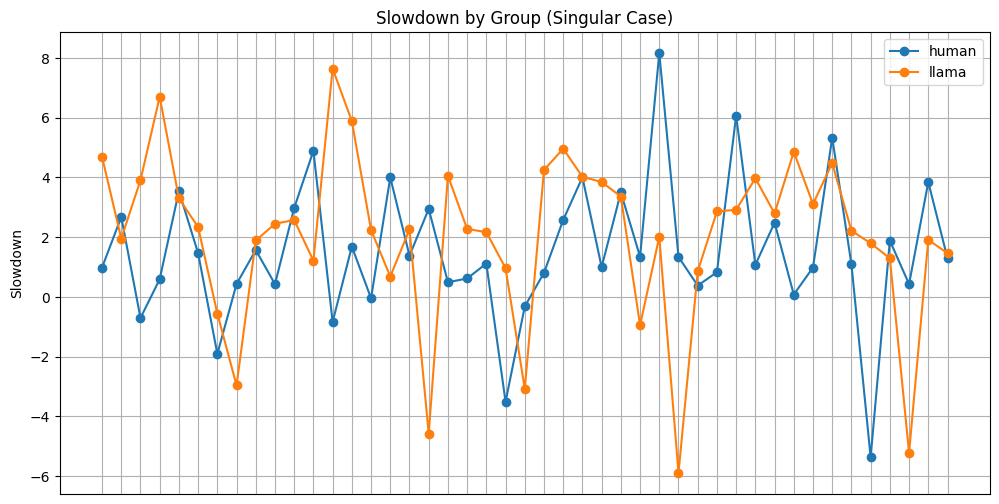

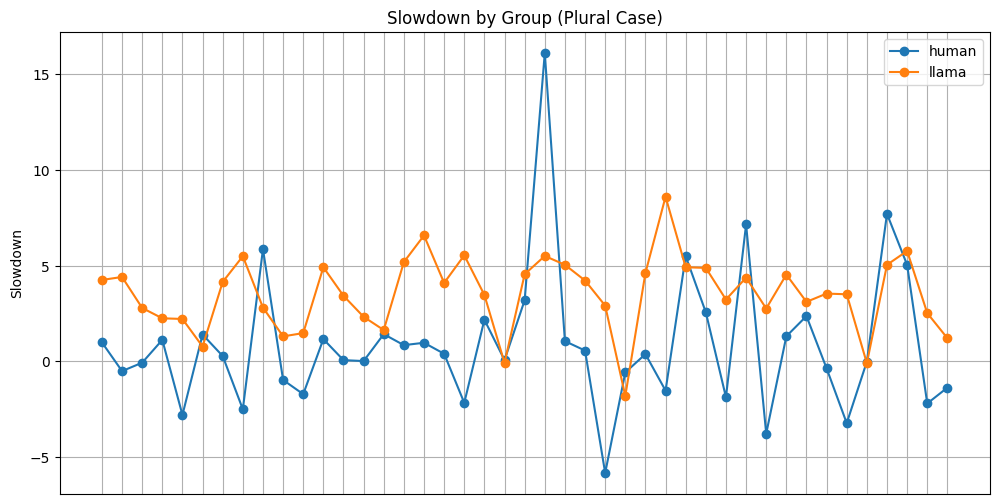

In [303]:
import matplotlib.pyplot as plt
import numpy as np

# Plotting function
def plot_slowdown_by_group(df, condition, title):
    plt.figure(figsize=(12, 6))
    
    models = df["model"].unique()
    
    for model in models:
        model_df = df[df["model"] == model]
        plt.plot(model_df["group"], model_df[f"slowdown_{condition}"], marker='o', label=model)
    
    plt.ylabel("Slowdown")
    plt.title(title)
    plt.legend()
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False) 
    plt.grid(True)
    plt.show()

# Plotting for singular case
plot_slowdown_by_group(df_subset_singular, "singular", "Slowdown by Group (Singular Case)")

# Plotting for plural case
plot_slowdown_by_group(df_subset_plural, "plural", "Slowdown by Group (Plural Case)")


**Q1**: Hypothesis: If the prediction is true, the surprisal value (for LMs) or reading time (RT) (for humans) should be larger in the mismatched condition than in the matched condition.

Formally:

-  $\text{Surprisal}_{\text{mismatch}} > \text{Surprisal}_{\text{match}}$  (for LMs)
- $\text{RT}_{\text{mismatch}} > \text{RT}_{\text{match}}$  (for humans)

**Q2**:

* SRC (subject relative clause modifier):
    * mismatch singular: The pilot that injured the teacher bring love to people.
    * match singular: The pilot that injured the teacher brings love to people.
* ORC (object relative clause modifier):
    * mismatch singular: The minister that the manager injured know tennis.
    * match singular: The minister that the manager injured knows tennis.
* PP (prepositional phrase modifier):
    * mismatch singular: The executive next to the teacher are good.
    * match singular: The executive next to the teacher is good.

**Q3**: According to the paper by [Wilcox _et al._ (2021)](https://arxiv.org/pdf/2106.03232), reaction times (RT) are provided in milliseconds and surprisals are given in bits.


**Q4**: Different plots are provided in the above section. Last bar plot which shows the Accuracy Scores Human RTs vs. Model Surprisals plot complies with Figure 6 in the paper (except **Llama**, which is not present in the paper). 

**Q5**:  Human RTs are at or below chance for the Subject-Verb Number Agreement with an Object Relative Clause modifier and Subject Relative Clause modifier for the plural case. In the paper, correlations between model accuracy scores and human consistency scores across test suites are provided. Similarly, Pearson correlation statistics based on the given 3 test suites can be found below: 

### Plural Case

| Model | Correlation | $p$-Value |
|:-------:|:-------------:|:---------:|
| gpt2  | 0.99        | 0.01    |
| rnng*  | -         | -     |
| jrnn  | 0.59        | 0.60    |
| grnn  | 0.41        | 0.73    |
| llama | -0.14       | 0.91    |

### Singular Case

| Model | Correlation | $p$-Value |
|:-------:|:-------------:|:---------:|
| gpt2  | 0.83        | 0.38    |
| rnng  | -0.23       | 0.85    |
| jrnn  | 0.82        | 0.39    |
| grnn  | 0.64        | 0.56    |
| llama | -0.17       | 0.89    |

For the singular case, there doesn't seem to be a correlation between the human RTs and model surprisals. For the plural case, **GPT-2** seems to correlate with human RTs. As can be seen from the plot, **GPT-2** is the only model that shows a positive correlation with human RTs for plural cases - where its accuracy increases when human accuracy increases and decreases when human accuracy decreases. However, as we have limited number of test suites, we should be cautious about generalizing these results.

*: Accuracy of the **RNNG** is always $100\%$ for plural mismatches across the given test suites, yielding a correlation of $0$.

**Q6**: Based on the plots, the lower accuracy results indicate that humans can detect mismatches in plural cases more easily than in singular cases. In the Subject-Verb Number Agreement test suite with a Subject Relative Clause modifier, humans even tend to spend more time on correctly matched plural cases rather than on mismatched ones, resulting in accuracy lower than chance. Conversely, models tend to produce higher surprisal values for mismatches in plural cases. Across all models, in 11 out of 12 cases, they achieve higher accuracy in plural cases compared to singular cases. This suggests that models are more proficient at detecting mismatches in plural cases, as indicated by their higher surprisal levels when encountering unexpected grammatical structures.

**Q7**: You can find the reported correlations between the processing ‘difficulty’ of Llama with the processing slowdown of humans, down below:

| Case        | Correlation Method                | Statistics              | $p$-value              |
| :-------------: | :-----------------------: | :-----------------------: |:-----------------------: |
| Plural       | Pearson correlation<br>Spearman Correlation | 0.27<br>0.32 | 0.08<br>0.04 |
| Singular       | Pearson correlation<br>Spearman Correlation | 0.07<br>0.05 | 0.66<br>0.76 |

In the paper, different conversion rates (ms/bit) are used to convert surprisal difference into estimated slowdown time assuming a linear relationship between surprisal and human reaction time. To measure the correlation, this step is not important as the multiplication by a constant doesn't change the correlation coefficient. We calculated both the Spearman correlation coefficient and Pearson correlation coefficient. According to a highly cited paper by [Schober et al., 2018](https://pubmed.ncbi.nlm.nih.gov/29481436/), correlation statistics $0.1 ≤ \gamma ≤ 0.39$ is considered a weak correlation. Based on this, we can say that there exists a weak correlation $\gamma = 0.32$ between the processing difficulty of Llama and the processing slowdown of humans for the plural case ($p$-value $< 0.05$). Spearman reports even a stronger correlation, but with a higher $p$-value ($0.08$). On the other hand, for the singular case, we should maintain the null hypothesis that there exists no statistically significant correlation ($p$-value $> 0.05$ for both of the methods).

At the end, plots of the slowdown of human RTs and the surprisal values of the models are provided. Slowdowns of human RTs are scaled to the range of the surprisal values of the models (which does not affect the correlation statistics).